In [1]:
import torch
from torch import nn
from torch.distributions import Poisson, Gamma
import matplotlib.pyplot as plt
from case_studies.dc2_mdt.utils.nfdm import NeuralFlowDiffusion
import numpy as np
from einops import rearrange
import pytorch_lightning
import tqdm

In [2]:
device = torch.device("cuda:6")
batch_size = 1024
val_batch_size = 2048  # 30_000
training_iters = 100_000  # 5000
val_iters = 100  # 5000
log_freq = 500
seed = 1201023
pytorch_lightning.seed_everything(seed)

Seed set to 1201023


1201023

In [3]:
image_normalize_strategy = "linear_scale"

In [4]:
class ConstantLocsPrior:
    def __init__(self, low, high, offset):
        self.low = low
        self.high = high
        self.offset = offset

    def sample(self, sample_shape):
        mid_point = (self.low + self.high) / 2
        m = sample_shape[-1]
        mid_point = torch.stack([mid_point + self.offset * i for i in range(m)], dim=0)
        assert (mid_point <= self.high).all()
        return torch.ones(sample_shape[:-1]).unsqueeze(-1).unsqueeze(-1) * mid_point
    

class CatalogPrior:
    def __init__(
        self,
        num_objects: int,
        img_height: int,
        img_width: int,
        locs_offset: float,
        flux_alpha: float,
        flux_beta: float,
    ):
        self.num_objects = num_objects
        self.img_height = img_height
        self.img_width = img_width
        self.flux_prior = Gamma(torch.tensor(flux_alpha), 
                                torch.tensor(flux_beta))
        self.loc_prior = ConstantLocsPrior(torch.zeros(2), 
                                           torch.tensor((self.img_height, self.img_width)),
                                           offset=locs_offset)

    def sample(
        self,
        num_catalogs,
    ):
        fluxes = self.flux_prior.sample([num_catalogs, self.num_objects])  # (n_catalogs, m)
        locs = self.loc_prior.sample(
            [num_catalogs, self.num_objects]
        )  # (n_catalogs, m, 2)
        return {
            "count": torch.full((num_catalogs, ), fill_value=self.num_objects),
            "fluxes": fluxes, 
            "locs": locs
        }



class ImageSimulator(nn.Module):
    def __init__(
        self,
        img_height: int,
        img_width: int,
        num_objects: int,
        locs_offset: float,
        flux_alpha: float,
        flux_beta: float,
        psf_stdev: float,
        background_intensity: float,
    ):
        super().__init__()

        self.img_height = img_height
        self.img_width = img_width
        self.num_objects = num_objects

        self.psf_stdev = psf_stdev
        self.background_intensity = background_intensity

        self.catalog_prior = CatalogPrior(num_objects=num_objects,
                                          img_height=img_height,
                                          img_width=img_width,
                                          locs_offset=locs_offset,
                                          flux_alpha=flux_alpha,
                                          flux_beta=flux_beta)

        self.register_buffer("dummy_param", torch.zeros(0))
        self.register_buffer("psf_marginal_h",
                             (0.5 + torch.arange(self.img_height, dtype=torch.float32)).view(1, self.img_height, 1, 1))
        self.register_buffer("psf_marginal_w",
                             (0.5 + torch.arange(self.img_width, dtype=torch.float32)).view(1, 1, self.img_width, 1))

    @property
    def device(self):
        return self.dummy_param.device

    def psf(self, loc_h, loc_w):
        logpsf = -(
            (self.psf_marginal_h - loc_h.view(-1, 1, 1, self.num_objects)) ** 2
            + (self.psf_marginal_w - loc_w.view(-1, 1, 1, self.num_objects)) ** 2
        ) / (2 * self.psf_stdev ** 2)
        return torch.exp(logpsf - logpsf.logsumexp(dim=(1, 2), keepdim=True))
    
    def _generate(self, batch_size):
        tile_cat = self.catalog_prior.sample(num_catalogs=batch_size)
        tile_cat = {k: v.to(device=self.device) for k, v in tile_cat.items()}
        psf = self.psf(tile_cat["locs"][:, :, 0], tile_cat["locs"][:, :, 1])  # (b, h, w, m)
        source_intensities = (tile_cat["fluxes"].view(batch_size, 1, 1, self.num_objects) * psf).sum(dim=3)  # (b, h, w)
        total_intensities = source_intensities + self.background_intensity
        images = Poisson(total_intensities).sample()
        return {
            **tile_cat, 
            "psf": psf,
            "source_intensities": source_intensities,
            "total_intensities": total_intensities, 
            "images": images
        }
    
    def generate(self, batch_size, *, seed=None):
        if seed is not None:
            with torch.random.fork_rng(devices=["cpu", self.device]):
                torch.manual_seed(seed)
                output = self._generate(batch_size)
        else:
            output = self._generate(batch_size)
        return output


In [5]:
image_size = 4
num_objects = 2
background_intensity = 50.0
image_simulator = ImageSimulator(img_height=image_size, 
                                    img_width=image_size, 
                                    num_objects=num_objects, 
                                    locs_offset=0.5,
                                    flux_alpha=10.0,
                                    flux_beta=0.01,
                                    psf_stdev=1.0, 
                                    background_intensity=background_intensity).to(device=device)

In [6]:
class Net(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, out_dim),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [7]:
class AffineNeuralFLow(nn.Module):
    def __init__(self, d: int):
        super().__init__()
        self.net = Net(d + 1, d * 2)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        m, ls = self.net(torch.cat([x, t], dim=-1)).chunk(2, dim=-1)
        m = (1 - t) * x + t * (1 - t) * m
        ls = (1 - t) * np.log(0.01) + t * (1 - t) * ls
        return m, torch.exp(ls)

class VolatilityNeural(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = Net(1, 1)
        self.sp = nn.Softplus()

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        return self.sp(self.net(t))

In [8]:
class SimpleMLP(nn.Module):
    def __init__(self, layers, hidden_ch):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(1 + 1 + image_size * image_size, hidden_ch),
            nn.SELU(),
            *[
                nn.Sequential(
                    nn.Linear(hidden_ch, hidden_ch),
                    nn.SELU(),
                ) for _ in range(layers)
            ],
            nn.Linear(hidden_ch, 1)
        )
    
    def forward(self, xt, t, image):
        x = torch.cat([xt, t, image.flatten(start_dim=1)], dim=1)
        return self.network(x)

In [9]:
class FourierMLP(nn.Module):
    def __init__(self, data_shape, num_layers, hidden_ch):
        super().__init__()
        self.data_shape = [data_shape]

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=hidden_ch)[None]
        )
        self.timestep_phase = nn.Parameter(torch.randn(hidden_ch)[None])
        self.input_embed = nn.Sequential(
            nn.Linear(int(np.prod(data_shape)), hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * hidden_ch, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch),
        )
        self.image_embed = nn.Sequential(
            nn.Linear(image_size * image_size, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.layers = nn.Sequential(
            nn.Linear(hidden_ch * 2, hidden_ch), 
            nn.GELU(),
            *[
                nn.Sequential(nn.Linear(hidden_ch, hidden_ch), nn.GELU())
                for _ in range(num_layers)
            ],
            nn.Linear(hidden_ch, int(np.prod(data_shape))),
        )

    def forward(self, xt, t, image):
        sin_embed_t = torch.sin(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        cos_embed_t = torch.cos(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        embed_t = self.timestep_embed(
            rearrange([sin_embed_t, cos_embed_t], "d b w -> b (d w)")
        )
        embed_xt = self.input_embed(xt.view(xt.shape[0], -1))
        embed_image = self.image_embed(image.flatten(1))
        out = self.layers(
            torch.cat([embed_xt + embed_t, embed_image], dim=-1)
        )
        return out.view(xt.shape)

In [10]:
nfd = NeuralFlowDiffusion(sde_sampling_steps=300, ode_sampling_steps=300)

In [11]:
affine_transform_model = AffineNeuralFLow(d=1).to(device=device)
volatility_model = VolatilityNeural().to(device=device)
# x0_model = FourierMLP(data_shape=[1,], 
#                         num_layers=8, 
#                         hidden_ch=256).to(device=device)
x0_model = SimpleMLP(layers=8, hidden_ch=256).to(device=device)
my_optimizer = torch.optim.Adam(list(affine_transform_model.parameters()) + \
                                list(volatility_model.parameters()) + \
                                list(x0_model.parameters()), lr=1e-3, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 4 * 3], gamma=0.1)

In [12]:
max_flux_boundary = 2000.0
def encode_flux(flux: torch.Tensor):
    assert flux.min() >= 0.0
    flux = flux.clamp(max=max_flux_boundary)
    return (flux / max_flux_boundary) * 2 - 1

def decode_flux(flux_minus1_to_1: torch.Tensor):
    assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
    return (flux_minus1_to_1 + 1) / 2 * max_flux_boundary

In [13]:
affine_transform_model.train()
volatility_model.train()
x0_model.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    t = torch.rand(batch_size, 1, device=device)
    assert catalog["fluxes"].ndim == 2
    assert catalog["images"].ndim == 3
    target_fluxes = catalog["fluxes"][:, 0:1]  # (b, 1)
    input_image = catalog["images"]  # (b, h, w)
    match image_normalize_strategy:
        case "none":
            pass
        case "log":
            input_image = torch.log1p(input_image)
        case "linear_scale":
            input_image = input_image / 1000
        case _:
            raise NotImplementedError()
    x_start = encode_flux(target_fluxes)
    loss = nfd.training_losses(affine_transform_model=affine_transform_model,
                               volatility_model=volatility_model,
                               x0_model=x0_model,
                               x_start=x_start,
                               t=t, 
                               x0_model_kwargs={"image": input_image})["loss"]
    loss = loss.mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

  1%|          | 505/100000 [00:12<38:21, 43.23it/s] 

[500/100000] loss: 5.527e+02


  1%|          | 1006/100000 [00:23<38:09, 43.24it/s]

[1000/100000] loss: 4.433e+02


  2%|▏         | 1506/100000 [00:35<38:43, 42.39it/s]

[1500/100000] loss: 4.113e+02


  2%|▏         | 2009/100000 [00:46<33:47, 48.33it/s]

[2000/100000] loss: 3.938e+02


  3%|▎         | 2508/100000 [00:57<37:13, 43.65it/s]

[2500/100000] loss: 4.471e+02


  3%|▎         | 3004/100000 [01:08<36:24, 44.40it/s]

[3000/100000] loss: 4.561e+02


  4%|▎         | 3507/100000 [01:20<36:30, 44.05it/s]

[3500/100000] loss: 4.959e+02


  4%|▍         | 4005/100000 [01:31<28:05, 56.96it/s]

[4000/100000] loss: 4.792e+02


  5%|▍         | 4506/100000 [01:41<35:54, 44.32it/s]

[4500/100000] loss: 5.340e+02


  5%|▌         | 5006/100000 [01:52<36:30, 43.36it/s]

[5000/100000] loss: 4.446e+02


  6%|▌         | 5506/100000 [02:04<36:27, 43.20it/s]

[5500/100000] loss: 5.307e+02


  6%|▌         | 6006/100000 [02:15<35:07, 44.61it/s]

[6000/100000] loss: 4.879e+02


  7%|▋         | 6506/100000 [02:27<36:46, 42.37it/s]

[6500/100000] loss: 4.358e+02


  7%|▋         | 7006/100000 [02:39<35:59, 43.06it/s]

[7000/100000] loss: 5.413e+02


  8%|▊         | 7506/100000 [02:50<36:03, 42.76it/s]

[7500/100000] loss: 4.753e+02


  8%|▊         | 8006/100000 [03:02<36:36, 41.88it/s]

[8000/100000] loss: 4.159e+02


  9%|▊         | 8506/100000 [03:13<34:53, 43.70it/s]

[8500/100000] loss: 4.677e+02


  9%|▉         | 9006/100000 [03:25<35:29, 42.72it/s]

[9000/100000] loss: 4.030e+02


 10%|▉         | 9506/100000 [03:36<34:57, 43.13it/s]

[9500/100000] loss: 3.813e+02


 10%|█         | 10008/100000 [03:48<34:45, 43.16it/s]

[10000/100000] loss: 4.034e+02


 11%|█         | 10508/100000 [04:00<35:14, 42.33it/s]

[10500/100000] loss: 5.708e+02


 11%|█         | 11008/100000 [04:12<34:47, 42.63it/s]

[11000/100000] loss: 4.623e+02


 12%|█▏        | 11508/100000 [04:23<34:07, 43.22it/s]

[11500/100000] loss: 5.051e+02


 12%|█▏        | 12008/100000 [04:35<33:47, 43.40it/s]

[12000/100000] loss: 5.361e+02


 13%|█▎        | 12508/100000 [04:46<33:56, 42.97it/s]

[12500/100000] loss: 3.796e+02


 13%|█▎        | 13008/100000 [04:58<33:25, 43.39it/s]

[13000/100000] loss: 4.015e+02


 14%|█▎        | 13506/100000 [05:09<33:26, 43.11it/s]

[13500/100000] loss: 3.461e+02


 14%|█▍        | 14006/100000 [05:21<33:23, 42.93it/s]

[14000/100000] loss: 4.061e+02


 15%|█▍        | 14506/100000 [05:33<33:05, 43.06it/s]

[14500/100000] loss: 5.400e+02


 15%|█▌        | 15006/100000 [05:44<32:51, 43.11it/s]

[15000/100000] loss: 4.819e+02


 16%|█▌        | 15506/100000 [05:56<32:35, 43.21it/s]

[15500/100000] loss: 5.171e+02


 16%|█▌        | 16006/100000 [06:07<32:13, 43.45it/s]

[16000/100000] loss: 4.518e+02


 17%|█▋        | 16506/100000 [06:19<32:12, 43.20it/s]

[16500/100000] loss: 4.104e+02


 17%|█▋        | 17006/100000 [06:30<32:21, 42.75it/s]

[17000/100000] loss: 4.177e+02


 18%|█▊        | 17507/100000 [06:42<31:34, 43.53it/s]

[17500/100000] loss: 5.726e+02


 18%|█▊        | 18006/100000 [06:53<30:25, 44.91it/s]

[18000/100000] loss: 4.435e+02


 19%|█▊        | 18505/100000 [07:04<30:32, 44.48it/s]

[18500/100000] loss: 4.194e+02


 19%|█▉        | 19005/100000 [07:15<30:51, 43.74it/s]

[19000/100000] loss: 4.387e+02


 20%|█▉        | 19506/100000 [07:26<30:15, 44.33it/s]

[19500/100000] loss: 4.354e+02


 20%|██        | 20006/100000 [07:38<30:34, 43.60it/s]

[20000/100000] loss: 4.974e+02


 21%|██        | 20506/100000 [07:49<30:53, 42.89it/s]

[20500/100000] loss: 3.291e+02


 21%|██        | 21006/100000 [08:01<30:36, 43.02it/s]

[21000/100000] loss: 4.590e+02


 22%|██▏       | 21506/100000 [08:12<30:10, 43.36it/s]

[21500/100000] loss: 4.933e+02


 22%|██▏       | 22006/100000 [08:24<30:22, 42.79it/s]

[22000/100000] loss: 4.674e+02


 23%|██▎       | 22506/100000 [08:36<30:08, 42.86it/s]

[22500/100000] loss: 5.780e+02


 23%|██▎       | 23006/100000 [08:47<29:21, 43.72it/s]

[23000/100000] loss: 5.698e+02


 24%|██▎       | 23507/100000 [08:59<30:12, 42.19it/s]

[23500/100000] loss: 4.686e+02


 24%|██▍       | 24007/100000 [09:10<29:30, 42.93it/s]

[24000/100000] loss: 3.568e+02


 25%|██▍       | 24507/100000 [09:22<28:54, 43.52it/s]

[24500/100000] loss: 4.380e+02


 25%|██▌       | 25007/100000 [09:34<28:54, 43.24it/s]

[25000/100000] loss: 5.534e+02


 26%|██▌       | 25505/100000 [09:45<28:22, 43.75it/s]

[25500/100000] loss: 5.417e+02


 26%|██▌       | 26005/100000 [09:57<27:09, 45.42it/s]

[26000/100000] loss: 4.032e+02


 27%|██▋       | 26504/100000 [10:08<25:59, 47.12it/s]

[26500/100000] loss: 5.030e+02


 27%|██▋       | 27006/100000 [10:19<24:16, 50.12it/s]

[27000/100000] loss: 5.698e+02


 28%|██▊       | 27506/100000 [10:30<24:45, 48.81it/s]

[27500/100000] loss: 4.364e+02


 28%|██▊       | 28004/100000 [10:41<26:50, 44.72it/s]

[28000/100000] loss: 4.574e+02


 29%|██▊       | 28505/100000 [10:53<26:50, 44.39it/s]

[28500/100000] loss: 4.718e+02


 29%|██▉       | 29005/100000 [11:04<27:13, 43.47it/s]

[29000/100000] loss: 4.872e+02


 30%|██▉       | 29506/100000 [11:16<27:38, 42.49it/s]

[29500/100000] loss: 5.251e+02


 30%|███       | 30007/100000 [11:27<27:08, 42.98it/s]

[30000/100000] loss: 4.828e+02


 31%|███       | 30508/100000 [11:39<27:13, 42.54it/s]

[30500/100000] loss: 4.896e+02


 31%|███       | 31008/100000 [11:51<26:39, 43.13it/s]

[31000/100000] loss: 4.827e+02


 32%|███▏      | 31508/100000 [12:02<26:20, 43.33it/s]

[31500/100000] loss: 4.540e+02


 32%|███▏      | 32008/100000 [12:14<26:17, 43.09it/s]

[32000/100000] loss: 4.971e+02


 33%|███▎      | 32508/100000 [12:25<26:01, 43.21it/s]

[32500/100000] loss: 4.483e+02


 33%|███▎      | 33008/100000 [12:37<26:37, 41.92it/s]

[33000/100000] loss: 4.570e+02


 34%|███▎      | 33508/100000 [12:48<24:59, 44.34it/s]

[33500/100000] loss: 4.802e+02


 34%|███▍      | 34008/100000 [12:59<24:20, 45.17it/s]

[34000/100000] loss: 4.395e+02


 35%|███▍      | 34504/100000 [13:10<24:45, 44.09it/s]

[34500/100000] loss: 3.879e+02


 35%|███▌      | 35009/100000 [13:22<23:39, 45.78it/s]

[35000/100000] loss: 5.020e+02


 36%|███▌      | 35504/100000 [13:33<24:14, 44.35it/s]

[35500/100000] loss: 5.336e+02


 36%|███▌      | 36005/100000 [13:44<24:37, 43.32it/s]

[36000/100000] loss: 4.286e+02


 37%|███▋      | 36506/100000 [13:56<24:06, 43.90it/s]

[36500/100000] loss: 4.812e+02


 37%|███▋      | 37006/100000 [14:08<24:54, 42.15it/s]

[37000/100000] loss: 4.824e+02


 38%|███▊      | 37506/100000 [14:19<23:42, 43.94it/s]

[37500/100000] loss: 4.655e+02


 38%|███▊      | 38006/100000 [14:31<23:43, 43.56it/s]

[38000/100000] loss: 4.842e+02


 39%|███▊      | 38506/100000 [14:42<23:57, 42.79it/s]

[38500/100000] loss: 4.427e+02


 39%|███▉      | 39006/100000 [14:54<24:16, 41.88it/s]

[39000/100000] loss: 5.672e+02


 40%|███▉      | 39507/100000 [15:05<23:17, 43.28it/s]

[39500/100000] loss: 4.428e+02


 40%|████      | 40007/100000 [15:17<23:22, 42.77it/s]

[40000/100000] loss: 4.078e+02


 41%|████      | 40507/100000 [15:28<22:00, 45.04it/s]

[40500/100000] loss: 4.326e+02


 41%|████      | 41007/100000 [15:40<22:43, 43.26it/s]

[41000/100000] loss: 4.309e+02


 42%|████▏     | 41508/100000 [15:51<22:00, 44.28it/s]

[41500/100000] loss: 4.720e+02


 42%|████▏     | 42008/100000 [16:03<22:35, 42.77it/s]

[42000/100000] loss: 4.068e+02


 43%|████▎     | 42508/100000 [16:14<21:04, 45.47it/s]

[42500/100000] loss: 5.127e+02


 43%|████▎     | 43004/100000 [16:25<22:35, 42.04it/s]

[43000/100000] loss: 3.851e+02


 44%|████▎     | 43507/100000 [16:37<21:43, 43.35it/s]

[43500/100000] loss: 4.398e+02


 44%|████▍     | 44007/100000 [16:49<21:37, 43.17it/s]

[44000/100000] loss: 4.806e+02


 45%|████▍     | 44507/100000 [17:00<20:56, 44.17it/s]

[44500/100000] loss: 4.872e+02


 45%|████▌     | 45007/100000 [17:11<20:32, 44.62it/s]

[45000/100000] loss: 4.044e+02


 46%|████▌     | 45507/100000 [17:23<20:25, 44.47it/s]

[45500/100000] loss: 5.225e+02


 46%|████▌     | 46007/100000 [17:34<20:20, 44.23it/s]

[46000/100000] loss: 4.990e+02


 47%|████▋     | 46504/100000 [17:45<20:37, 43.22it/s]

[46500/100000] loss: 4.758e+02


 47%|████▋     | 47004/100000 [17:56<20:29, 43.10it/s]

[47000/100000] loss: 4.586e+02


 48%|████▊     | 47504/100000 [18:08<20:16, 43.14it/s]

[47500/100000] loss: 4.437e+02


 48%|████▊     | 48004/100000 [18:20<20:06, 43.10it/s]

[48000/100000] loss: 4.308e+02


 49%|████▊     | 48508/100000 [18:31<19:16, 44.53it/s]

[48500/100000] loss: 4.894e+02


 49%|████▉     | 49005/100000 [18:43<19:04, 44.57it/s]

[49000/100000] loss: 5.186e+02


 50%|████▉     | 49504/100000 [18:54<19:05, 44.08it/s]

[49500/100000] loss: 4.362e+02


 50%|█████     | 50004/100000 [19:05<18:56, 44.00it/s]

[50000/100000] loss: 4.779e+02


 51%|█████     | 50505/100000 [19:16<18:30, 44.58it/s]

[50500/100000] loss: 4.756e+02


 51%|█████     | 51006/100000 [19:27<18:29, 44.16it/s]

[51000/100000] loss: 5.043e+02


 52%|█████▏    | 51504/100000 [19:39<19:01, 42.50it/s]

[51500/100000] loss: 5.403e+02


 52%|█████▏    | 52006/100000 [19:50<18:07, 44.13it/s]

[52000/100000] loss: 4.944e+02


 53%|█████▎    | 52506/100000 [20:01<17:51, 44.31it/s]

[52500/100000] loss: 4.445e+02


 53%|█████▎    | 53004/100000 [20:13<17:53, 43.77it/s]

[53000/100000] loss: 5.606e+02


 54%|█████▎    | 53507/100000 [20:24<17:36, 44.01it/s]

[53500/100000] loss: 4.550e+02


 54%|█████▍    | 54004/100000 [20:35<17:19, 44.26it/s]

[54000/100000] loss: 4.085e+02


 55%|█████▍    | 54507/100000 [20:46<16:12, 46.77it/s]

[54500/100000] loss: 5.103e+02


 55%|█████▌    | 55008/100000 [20:57<16:52, 44.44it/s]

[55000/100000] loss: 5.067e+02


 56%|█████▌    | 55507/100000 [21:09<16:41, 44.44it/s]

[55500/100000] loss: 5.174e+02


 56%|█████▌    | 56007/100000 [21:20<16:44, 43.78it/s]

[56000/100000] loss: 4.327e+02


 57%|█████▋    | 56505/100000 [21:31<16:25, 44.13it/s]

[56500/100000] loss: 4.198e+02


 57%|█████▋    | 57004/100000 [21:42<16:16, 44.05it/s]

[57000/100000] loss: 4.978e+02


 58%|█████▊    | 57505/100000 [21:53<16:15, 43.57it/s]

[57500/100000] loss: 3.618e+02


 58%|█████▊    | 58004/100000 [22:05<14:54, 46.93it/s]

[58000/100000] loss: 4.813e+02


 59%|█████▊    | 58506/100000 [22:16<15:39, 44.18it/s]

[58500/100000] loss: 5.110e+02


 59%|█████▉    | 59008/100000 [22:27<15:32, 43.97it/s]

[59000/100000] loss: 5.278e+02


 60%|█████▉    | 59508/100000 [22:38<15:19, 44.06it/s]

[59500/100000] loss: 5.153e+02


 60%|██████    | 60005/100000 [22:49<15:05, 44.18it/s]

[60000/100000] loss: 4.538e+02


 61%|██████    | 60504/100000 [23:00<13:08, 50.11it/s]

[60500/100000] loss: 5.329e+02


 61%|██████    | 61005/100000 [23:12<14:45, 44.04it/s]

[61000/100000] loss: 4.741e+02


 62%|██████▏   | 61508/100000 [23:23<14:57, 42.87it/s]

[61500/100000] loss: 4.209e+02


 62%|██████▏   | 62006/100000 [23:34<12:43, 49.75it/s]

[62000/100000] loss: 5.169e+02


 63%|██████▎   | 62506/100000 [23:45<13:44, 45.45it/s]

[62500/100000] loss: 4.026e+02


 63%|██████▎   | 63008/100000 [23:57<12:47, 48.20it/s]

[63000/100000] loss: 5.081e+02


 64%|██████▎   | 63508/100000 [24:08<13:35, 44.72it/s]

[63500/100000] loss: 4.565e+02


 64%|██████▍   | 64006/100000 [24:19<12:38, 47.46it/s]

[64000/100000] loss: 4.718e+02


 65%|██████▍   | 64505/100000 [24:30<13:18, 44.47it/s]

[64500/100000] loss: 4.741e+02


 65%|██████▌   | 65005/100000 [24:41<12:51, 45.36it/s]

[65000/100000] loss: 4.609e+02


 66%|██████▌   | 65508/100000 [24:52<12:49, 44.83it/s]

[65500/100000] loss: 5.582e+02


 66%|██████▌   | 66007/100000 [25:03<12:41, 44.66it/s]

[66000/100000] loss: 4.434e+02


 67%|██████▋   | 66507/100000 [25:15<12:33, 44.42it/s]

[66500/100000] loss: 5.528e+02


 67%|██████▋   | 67005/100000 [25:26<11:46, 46.69it/s]

[67000/100000] loss: 4.501e+02


 68%|██████▊   | 67506/100000 [25:37<11:17, 47.97it/s]

[67500/100000] loss: 4.209e+02


 68%|██████▊   | 68005/100000 [25:48<11:59, 44.45it/s]

[68000/100000] loss: 3.941e+02


 69%|██████▊   | 68508/100000 [25:59<11:56, 43.92it/s]

[68500/100000] loss: 5.108e+02


 69%|██████▉   | 69012/100000 [26:08<06:46, 76.28it/s]

[69000/100000] loss: 5.150e+02


 70%|██████▉   | 69505/100000 [26:19<11:22, 44.67it/s]

[69500/100000] loss: 5.133e+02


 70%|███████   | 70004/100000 [26:30<10:59, 45.51it/s]

[70000/100000] loss: 5.189e+02


 71%|███████   | 70508/100000 [26:41<11:01, 44.59it/s]

[70500/100000] loss: 4.711e+02


 71%|███████   | 71005/100000 [26:52<10:49, 44.62it/s]

[71000/100000] loss: 5.243e+02


 72%|███████▏  | 71505/100000 [27:03<10:24, 45.65it/s]

[71500/100000] loss: 4.580e+02


 72%|███████▏  | 72006/100000 [27:13<10:22, 44.99it/s]

[72000/100000] loss: 4.989e+02


 73%|███████▎  | 72505/100000 [27:24<09:53, 46.29it/s]

[72500/100000] loss: 4.990e+02


 73%|███████▎  | 73011/100000 [27:33<08:51, 50.77it/s]

[73000/100000] loss: 4.471e+02


 74%|███████▎  | 73509/100000 [27:44<10:04, 43.79it/s]

[73500/100000] loss: 5.832e+02


 74%|███████▍  | 74008/100000 [27:55<09:49, 44.10it/s]

[74000/100000] loss: 5.035e+02


 75%|███████▍  | 74504/100000 [28:06<09:38, 44.08it/s]

[74500/100000] loss: 6.141e+02


 75%|███████▌  | 75006/100000 [28:17<09:27, 44.02it/s]

[75000/100000] loss: 4.384e+02


 76%|███████▌  | 75507/100000 [28:28<09:10, 44.50it/s]

[75500/100000] loss: 4.073e+02


 76%|███████▌  | 76004/100000 [28:40<09:04, 44.06it/s]

[76000/100000] loss: 5.102e+02


 77%|███████▋  | 76508/100000 [28:51<09:01, 43.38it/s]

[76500/100000] loss: 4.254e+02


 77%|███████▋  | 77006/100000 [29:02<08:42, 43.97it/s]

[77000/100000] loss: 4.784e+02


 78%|███████▊  | 77507/100000 [29:13<08:44, 42.86it/s]

[77500/100000] loss: 5.410e+02


 78%|███████▊  | 78004/100000 [29:25<08:11, 44.79it/s]

[78000/100000] loss: 4.065e+02


 79%|███████▊  | 78505/100000 [29:36<08:13, 43.57it/s]

[78500/100000] loss: 3.888e+02


 79%|███████▉  | 79007/100000 [29:47<07:48, 44.78it/s]

[79000/100000] loss: 4.957e+02


 80%|███████▉  | 79506/100000 [29:59<07:43, 44.18it/s]

[79500/100000] loss: 4.910e+02


 80%|████████  | 80007/100000 [30:10<07:12, 46.18it/s]

[80000/100000] loss: 4.477e+02


 81%|████████  | 80507/100000 [30:20<07:07, 45.63it/s]

[80500/100000] loss: 4.555e+02


 81%|████████  | 81007/100000 [30:31<06:51, 46.11it/s]

[81000/100000] loss: 4.101e+02


 82%|████████▏ | 81504/100000 [30:42<06:56, 44.41it/s]

[81500/100000] loss: 4.785e+02


 82%|████████▏ | 82004/100000 [30:54<06:50, 43.82it/s]

[82000/100000] loss: 4.707e+02


 83%|████████▎ | 82509/100000 [31:05<06:17, 46.28it/s]

[82500/100000] loss: 5.157e+02


 83%|████████▎ | 83009/100000 [31:16<06:07, 46.24it/s]

[83000/100000] loss: 4.822e+02


 84%|████████▎ | 83509/100000 [31:27<05:57, 46.14it/s]

[83500/100000] loss: 4.126e+02


 84%|████████▍ | 84005/100000 [31:38<06:02, 44.09it/s]

[84000/100000] loss: 4.001e+02


 85%|████████▍ | 84505/100000 [31:49<05:53, 43.85it/s]

[84500/100000] loss: 4.808e+02


 85%|████████▌ | 85007/100000 [32:00<05:44, 43.52it/s]

[85000/100000] loss: 4.654e+02


 86%|████████▌ | 85505/100000 [32:12<05:25, 44.48it/s]

[85500/100000] loss: 5.463e+02


 86%|████████▌ | 86007/100000 [32:23<05:08, 45.29it/s]

[86000/100000] loss: 4.732e+02


 87%|████████▋ | 86508/100000 [32:33<05:05, 44.23it/s]

[86500/100000] loss: 4.769e+02


 87%|████████▋ | 87006/100000 [32:45<04:55, 43.95it/s]

[87000/100000] loss: 4.560e+02


 88%|████████▊ | 87507/100000 [32:56<04:40, 44.50it/s]

[87500/100000] loss: 4.183e+02


 88%|████████▊ | 88005/100000 [33:07<04:28, 44.63it/s]

[88000/100000] loss: 4.027e+02


 89%|████████▊ | 88505/100000 [33:18<04:22, 43.86it/s]

[88500/100000] loss: 5.039e+02


 89%|████████▉ | 89008/100000 [33:29<04:17, 42.63it/s]

[89000/100000] loss: 6.058e+02


 90%|████████▉ | 89506/100000 [33:40<03:56, 44.40it/s]

[89500/100000] loss: 5.573e+02


 90%|█████████ | 90004/100000 [33:51<03:45, 44.38it/s]

[90000/100000] loss: 5.245e+02


 91%|█████████ | 90507/100000 [34:02<03:31, 44.88it/s]

[90500/100000] loss: 5.169e+02


 91%|█████████ | 91004/100000 [34:13<03:16, 45.68it/s]

[91000/100000] loss: 4.923e+02


 92%|█████████▏| 91506/100000 [34:24<03:11, 44.31it/s]

[91500/100000] loss: 4.053e+02


 92%|█████████▏| 92007/100000 [34:35<02:59, 44.63it/s]

[92000/100000] loss: 5.065e+02


 93%|█████████▎| 92506/100000 [34:47<02:47, 44.75it/s]

[92500/100000] loss: 3.542e+02


 93%|█████████▎| 93008/100000 [34:58<02:34, 45.30it/s]

[93000/100000] loss: 4.943e+02


 94%|█████████▎| 93509/100000 [35:09<02:25, 44.74it/s]

[93500/100000] loss: 5.568e+02


 94%|█████████▍| 94006/100000 [35:20<02:14, 44.50it/s]

[94000/100000] loss: 4.042e+02


 95%|█████████▍| 94507/100000 [35:31<02:02, 44.84it/s]

[94500/100000] loss: 4.335e+02


 95%|█████████▌| 95008/100000 [35:42<01:49, 45.61it/s]

[95000/100000] loss: 4.925e+02


 96%|█████████▌| 95505/100000 [35:53<01:41, 44.23it/s]

[95500/100000] loss: 5.231e+02


 96%|█████████▌| 96007/100000 [36:04<01:12, 55.36it/s]

[96000/100000] loss: 3.721e+02


 97%|█████████▋| 96508/100000 [36:16<01:17, 44.95it/s]

[96500/100000] loss: 5.057e+02


 97%|█████████▋| 97004/100000 [36:27<01:07, 44.09it/s]

[97000/100000] loss: 5.229e+02


 98%|█████████▊| 97504/100000 [36:38<00:57, 43.57it/s]

[97500/100000] loss: 4.000e+02


 98%|█████████▊| 98006/100000 [36:49<00:44, 44.59it/s]

[98000/100000] loss: 3.018e+02


 99%|█████████▊| 98505/100000 [37:01<00:33, 44.18it/s]

[98500/100000] loss: 3.711e+02


 99%|█████████▉| 99005/100000 [37:12<00:23, 42.10it/s]

[99000/100000] loss: 6.168e+02


100%|█████████▉| 99508/100000 [37:23<00:11, 44.56it/s]

[99500/100000] loss: 4.847e+02


100%|██████████| 100000/100000 [37:34<00:00, 44.35it/s]

[100000/100000] loss: 4.965e+02


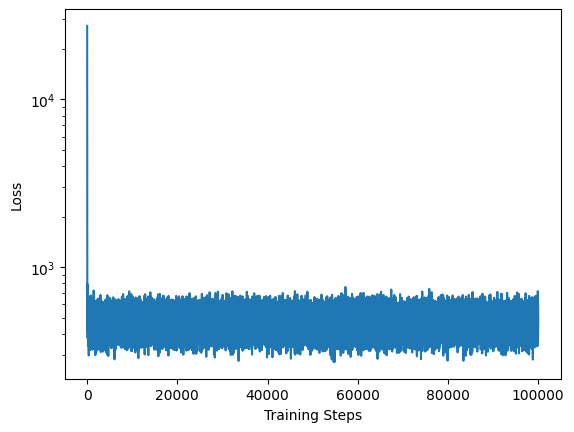

In [14]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [15]:
affine_transform_model.eval()
volatility_model.eval()
x0_model.eval()
val_true_fluxes = None
val_est_fluxes = []
with torch.inference_mode():
    val_catalog = image_simulator.generate(batch_size=val_batch_size, 
                                           seed=seed)
    for i in tqdm.tqdm(list(range(val_iters))):
        target_fluxes = val_catalog["fluxes"][:, 0:1]  # (b, 1)
        if val_true_fluxes is None:
            val_true_fluxes = target_fluxes
        else:
            assert torch.allclose(val_true_fluxes, target_fluxes)
        input_image = val_catalog["images"]
        match image_normalize_strategy:
            case "none":
                pass
            case "log":
                input_image = torch.log1p(input_image)
            case "linear_scale":
                input_image = input_image / 1000
            case _:
                raise NotImplementedError()
        sample = nfd.sde_sample(affine_transform_model=affine_transform_model,
                                volatility_model=volatility_model,
                                x0_model=x0_model,
                                shape=(val_batch_size, 1),
                                device=device,
                                x0_model_kwargs={"image": input_image})["samples"].clamp(min=-1.0, max=1.0)
        val_est_fluxes.append(decode_flux(sample).cpu())
val_est_fluxes = torch.stack(val_est_fluxes, dim=0)
val_true_fluxes = val_true_fluxes.cpu()

100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


In [16]:
val_true_fluxes.shape, val_est_fluxes.shape

(torch.Size([2048, 1]), torch.Size([100, 2048, 1]))

In [17]:
val_true_fluxes[:10]

tensor([[ 965.0724],
        [1202.7598],
        [ 563.8408],
        [ 955.3417],
        [ 767.1956],
        [ 892.2917],
        [1188.8887],
        [1554.3900],
        [1598.1493],
        [ 709.1891]])

In [18]:
val_est_fluxes[0, :10]

tensor([[ 985.8174],
        [1054.1636],
        [1023.7696],
        [ 972.0873],
        [ 995.0839],
        [1026.4945],
        [ 976.5193],
        [ 999.1147],
        [ 979.2342],
        [ 981.0217]])

In [19]:
torch.mean((val_true_fluxes - val_est_fluxes) ** 2)

tensor(99875.0781)

In [20]:
torch.mean(torch.abs(val_true_fluxes - val_est_fluxes))

tensor(249.1496)

In [21]:
ci_cover = torch.tensor([i / 100 for i in range(5, 100, 5)])
left_q_points = [(1.0 - c) / 2 for c in ci_cover]
right_q_points = [1.0 - lq for lq in left_q_points]
actual_ci_cover = []
for q in zip(left_q_points, right_q_points):
    q = torch.tensor(q)
    est_fluxes_q = val_est_fluxes.quantile(q=q, dim=0).permute([1, 2, 0])  # (b, 1, 2)
    above_lower_bound = val_true_fluxes[:, 0] > est_fluxes_q[:, 0, 0]
    below_upper_bound = val_true_fluxes[:, 0] < est_fluxes_q[:, 0, 1]
    actual_ci_cover.append((above_lower_bound & below_upper_bound).sum() / val_true_fluxes.shape[0])
actual_ci_cover = torch.cat([a.unsqueeze(0) for a in actual_ci_cover])

In [22]:
actual_ci_cover

tensor([0.0024, 0.0078, 0.0127, 0.0166, 0.0195, 0.0264, 0.0308, 0.0366, 0.0386,
        0.0430, 0.0483, 0.0537, 0.0562, 0.0596, 0.0645, 0.0713, 0.0820, 0.0898,
        0.1016])

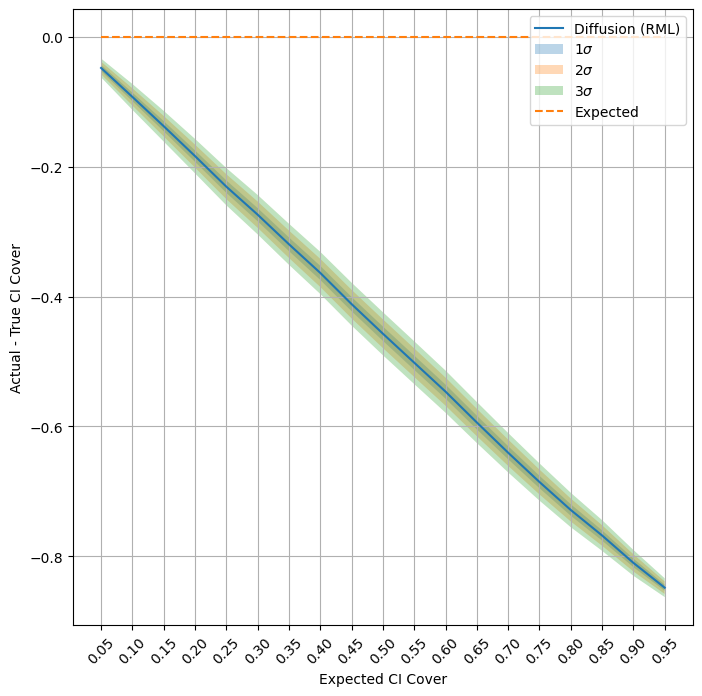

In [23]:
plt.figure(figsize=(8, 8))
a_m_c = actual_ci_cover - ci_cover
ci_sigma = (ci_cover * (1 - ci_cover) / val_batch_size) ** 0.5
plt.plot(ci_cover, a_m_c, label="Diffusion (RML)")
plt.fill_between(ci_cover, a_m_c - ci_sigma, a_m_c + ci_sigma, alpha=0.3, label=r"$1\sigma$")
plt.fill_between(ci_cover, a_m_c - 2 * ci_sigma, a_m_c + 2 * ci_sigma, alpha=0.3, label=r"$2\sigma$")
plt.fill_between(ci_cover, a_m_c - 3 * ci_sigma, a_m_c + 3 * ci_sigma, alpha=0.3, label=r"$3\sigma$")
plt.plot(ci_cover, torch.zeros_like(ci_cover), linestyle="dashed", label="Expected")
plt.legend(loc="upper right")
plt.grid()
plt.xticks(ci_cover, rotation=45)
plt.xlabel("Expected CI Cover")
plt.ylabel("Actual - True CI Cover")
plt.show()